### Renewable Energy Project 50MW Solar Farm Investment Analysis

Conduct Monte Carlo simulation-based risk analysis for investment project appraisal

##### Parameters:
- initial_investment: Initial capital outlay (positive number)
- project_life: Project duration in years
- discount_rate: Discount rate for NPV calculation
- revenue_params: Dictionary with revenue distribution parameters
- cost_params: Dictionary with cost distribution parameters  
- growth_params: Optional dictionary with growth rate parameters

    
##### PROJECT PARAMETERS:
  - Initial Investment: $50,000,000 \
  - Project Life: 25 years  \
  - Discount Rate: 10.0% 


##### NPV ANALYSIS:
 - Expected NPV: $23,911,587 
 - Median NPV: $23,929,787
 - Standard Deviation: $4,380,594
 - 5th Percentile (VaR): $16,635,697
 - 95th Percentile: $31,107,663
 - Probability of Positive NPV: 100.0%

##### IRR ANALYSIS:
 - Expected IRR: 12.8%  \
 - Probability IRR > Discount Rate: 100.0% \

##### PAYBACK ANALYSIS:\
 - Expected Payback Period: 7.9 years \
 - Probability of Payback within Project Life: 100.0% 


PROJECT PARAMETERS:
  Initial Investment: $50,000,000
  Project Life: 25 years
  Discount Rate: 10.0%
------------------------------------------------------------------------------------------

NPV ANALYSIS:
  Expected NPV: $12,002,547
  Median NPV: $12,026,077
  Standard Deviation: $3,793,653
  5th Percentile (VaR): $5,720,823
  95th Percentile: $18,257,242
  Probability of Positive NPV: 99.9%

IRR ANALYSIS:
  Expected IRR: 12.8%
  Probability IRR > Discount Rate: 99.9%

PAYBACK ANALYSIS:
  Expected Payback Period: 7.9 years
  Probability of Payback within Project Life: 100.0%

INVESTMENT RECOMMENDATION: STRONGLY RECOMMENDED
RISK LEVEL: LOW


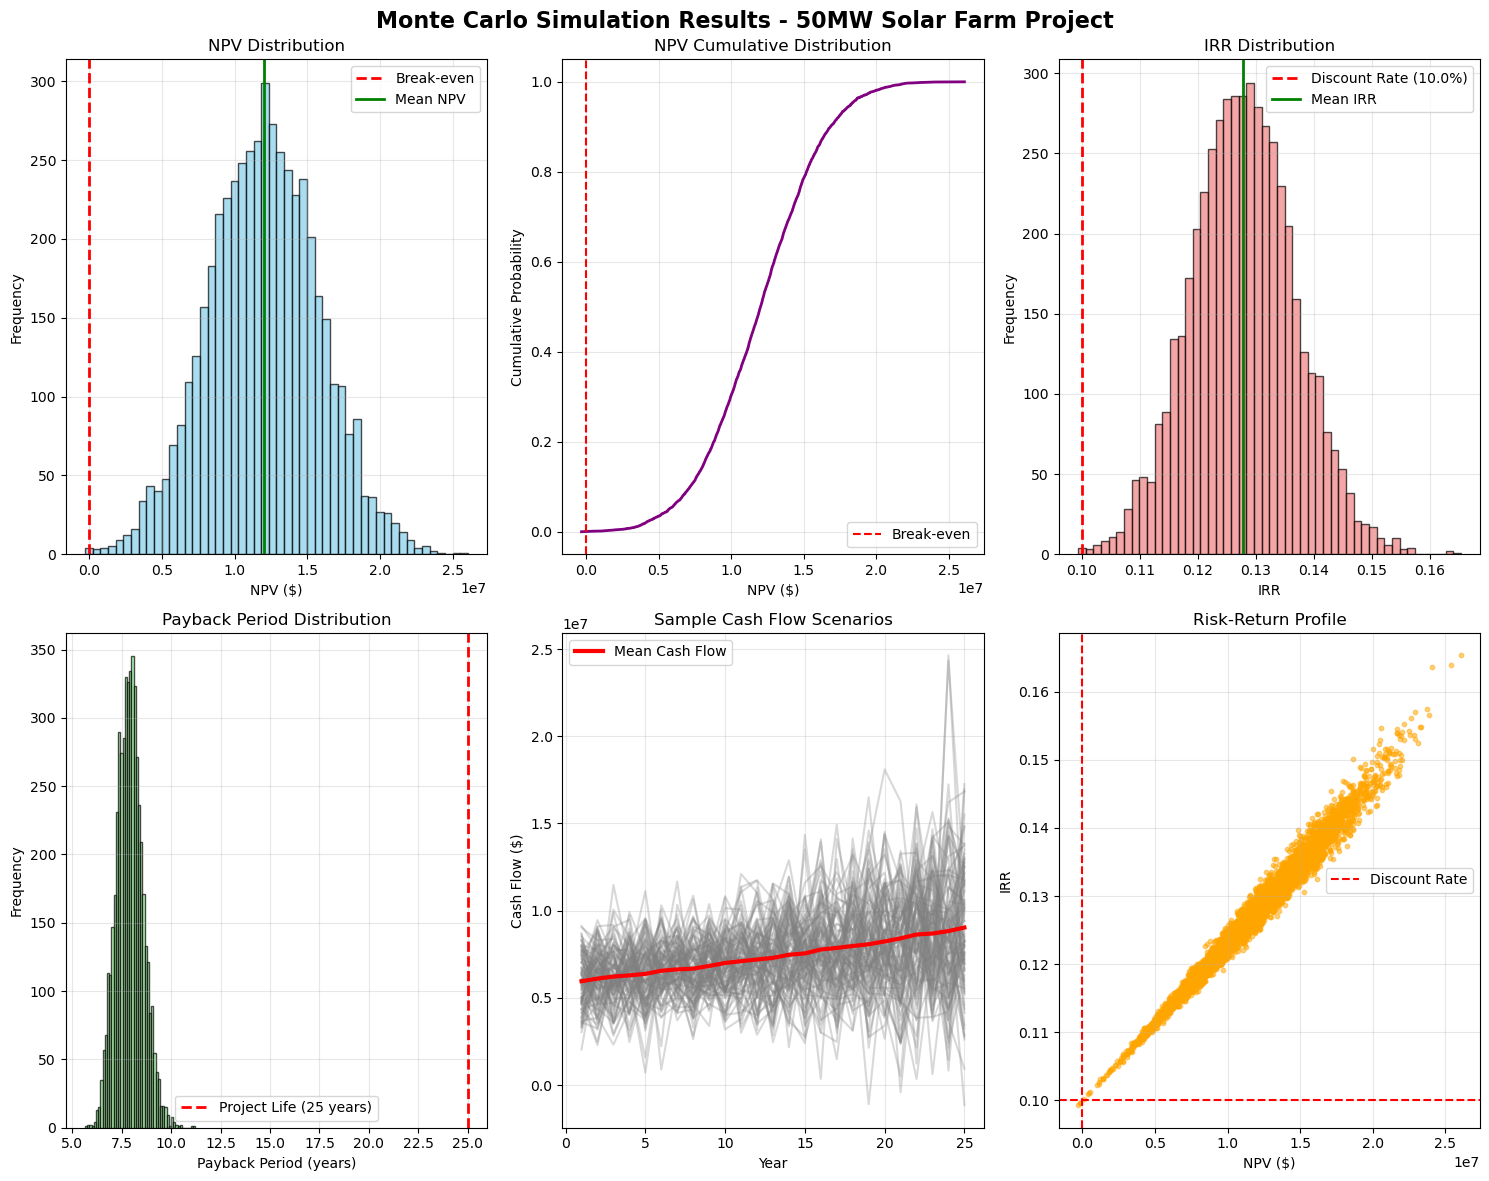

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class MonteCarloInvestmentAnalyzer:
    def __init__(self, project_name="Investment Project"):
        self.project_name = project_name
        self.simulation_results = None
        self.npv_results = None
        self.irr_results = None
        self.payback_results = None
        
    def define_project_parameters(self, initial_investment, project_life, discount_rate,
                                revenue_params, cost_params, growth_params=None):

        self.initial_investment = initial_investment
        self.project_life = project_life
        self.discount_rate = discount_rate
        self.revenue_params = revenue_params
        self.cost_params = cost_params
        self.growth_params = growth_params if growth_params else {}
        
    def _generate_revenue_scenario(self, year):
        dist_type = self.revenue_params.get('distribution', 'normal')
        
        if dist_type == 'normal':
            mean = self.revenue_params['mean']
            std = self.revenue_params['std']
            # Apply growth if specified
            if self.growth_params and 'revenue_growth' in self.growth_params:
                growth_mean = self.growth_params['revenue_growth']['mean']
                growth_std = self.growth_params['revenue_growth']['std']
                annual_growth = np.random.normal(growth_mean, growth_std)
                mean = mean * ((1 + annual_growth) ** year)
            return max(0, np.random.normal(mean, std))
            
        elif dist_type == 'lognormal':
            mean = self.revenue_params['mean']
            std = self.revenue_params['std']
            if self.growth_params and 'revenue_growth' in self.growth_params:
                growth_mean = self.growth_params['revenue_growth']['mean']
                growth_std = self.growth_params['revenue_growth']['std']
                annual_growth = np.random.normal(growth_mean, growth_std)
                mean = mean * ((1 + annual_growth) ** year)
            return np.random.lognormal(np.log(mean), std)
            
        elif dist_type == 'triangular':
            left = self.revenue_params['min']
            mode = self.revenue_params['most_likely']
            right = self.revenue_params['max']
            return np.random.triangular(left, mode, right)
    
    def _generate_cost_scenario(self, year):
        dist_type = self.cost_params.get('distribution', 'normal')
        
        if dist_type == 'normal':
            mean = self.cost_params['mean']
            std = self.cost_params['std']
            # Apply cost inflation if specified
            if self.growth_params and 'cost_inflation' in self.growth_params:
                inflation_mean = self.growth_params['cost_inflation']['mean']
                inflation_std = self.growth_params['cost_inflation']['std']
                annual_inflation = np.random.normal(inflation_mean, inflation_std)
                mean = mean * ((1 + annual_inflation) ** year)
            return max(0, np.random.normal(mean, std))
            
        elif dist_type == 'lognormal':
            mean = self.cost_params['mean']
            std = self.cost_params['std']
            if self.growth_params and 'cost_inflation' in self.growth_params:
                inflation_mean = self.growth_params['cost_inflation']['mean']
                inflation_std = self.growth_params['cost_inflation']['std']
                annual_inflation = np.random.normal(inflation_mean, inflation_std)
                mean = mean * ((1 + annual_inflation) ** year)
            return np.random.lognormal(np.log(mean), std)
            
        elif dist_type == 'triangular':
            left = self.cost_params['min']
            mode = self.cost_params['most_likely']
            right = self.cost_params['max']
            return np.random.triangular(left, mode, right)
    
    def calculate_npv(self, cash_flows, discount_rate):
        npv = -self.initial_investment  # Initial investment at time 0
        for t, cf in enumerate(cash_flows, 1):
            npv += cf / ((1 + discount_rate) ** t)
        return npv
    
    def calculate_irr(self, cash_flows, max_iterations=1000, tolerance=1e-6):
        # Initial guess
        irr = 0.1
        for _ in range(max_iterations):
            npv = -self.initial_investment
            d_npv = 0
            for t, cf in enumerate(cash_flows, 1):
                npv += cf / ((1 + irr) ** t)
                d_npv -= t * cf / ((1 + irr) ** (t + 1))
            
            if abs(npv) < tolerance:
                break
            if d_npv == 0:
                break
            irr = irr - npv / d_npv
            
        return irr if irr > -1 else float('nan')
    
    def calculate_payback_period(self, cash_flows):
        cumulative_cash_flow = -self.initial_investment
        for year, cf in enumerate(cash_flows, 1):
            cumulative_cash_flow += cf
            if cumulative_cash_flow >= 0:
                # Linear interpolation for fractional year
                previous_cumulative = cumulative_cash_flow - cf
                fraction = -previous_cumulative / cf
                return year - 1 + fraction
        return float('inf')  # Never pays back
    
    def run_simulation(self, n_simulations=10000):
   
        npv_results = []
        irr_results = []
        payback_results = []
        all_cash_flows = []
        
        for i in range(n_simulations):
            # Generate cash flows for each year
            cash_flows = []
            for year in range(self.project_life):
                revenue = self._generate_revenue_scenario(year)
                costs = self._generate_cost_scenario(year)
                cash_flow = revenue - costs
                cash_flows.append(cash_flow)
            
            all_cash_flows.append(cash_flows)
            
            # Calculate financial metrics
            npv = self.calculate_npv(cash_flows, self.discount_rate)
            irr = self.calculate_irr(cash_flows)
            payback = self.calculate_payback_period(cash_flows)
            
            npv_results.append(npv)
            irr_results.append(irr)
            payback_results.append(payback)
        
        # Store results
        self.npv_results = np.array(npv_results)
        self.irr_results = np.array(irr_results)
        self.payback_results = np.array(payback_results)
        self.all_cash_flows = np.array(all_cash_flows)
 
        
    def get_risk_metrics(self):
        if self.npv_results is None:
            raise ValueError("Simulation not run yet. Call run_simulation() first.")
        
        metrics = {
            'NPV': {
                'mean': np.mean(self.npv_results),
                'median': np.median(self.npv_results),
                'std': np.std(self.npv_results),
                'min': np.min(self.npv_results),
                'max': np.max(self.npv_results),
                'percentile_5': np.percentile(self.npv_results, 5),
                'percentile_95': np.percentile(self.npv_results, 95),
                'probability_positive': np.mean(self.npv_results > 0) * 100,
                'value_at_risk_95': np.percentile(self.npv_results, 5)  # 5th percentile
            },
            'IRR': {
                'mean': np.nanmean(self.irr_results),
                'median': np.nanmedian(self.irr_results),
                'std': np.nanstd(self.irr_results),
                'probability_above_discount_rate': np.nanmean(self.irr_results > self.discount_rate) * 100
            },
            'Payback Period': {
                'mean': np.nanmean(self.payback_results),
                'median': np.nanmedian(self.payback_results),
                'probability_within_project_life': np.nanmean(self.payback_results <= self.project_life) * 100
            }
        }
        
        return metrics
    
    def plot_results(self, figsize=(15, 12)):
        if self.npv_results is None:
            raise ValueError("Simulation not run yet. Call run_simulation() first.")
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle(f'Monte Carlo Simulation Results - {self.project_name}', fontsize=16, fontweight='bold')
        
        axes[0, 0].hist(self.npv_results, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
        axes[0, 0].axvline(np.mean(self.npv_results), color='green', linestyle='-', linewidth=2, label='Mean NPV')
        axes[0, 0].set_xlabel('NPV ($)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('NPV Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        sorted_npv = np.sort(self.npv_results)
        cumulative_prob = np.arange(1, len(sorted_npv) + 1) / len(sorted_npv)
        axes[0, 1].plot(sorted_npv, cumulative_prob, color='purple', linewidth=2)
        axes[0, 1].axvline(0, color='red', linestyle='--', label='Break-even')
        axes[0, 1].set_xlabel('NPV ($)')
        axes[0, 1].set_ylabel('Cumulative Probability')
        axes[0, 1].set_title('NPV Cumulative Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        valid_irr = self.irr_results[~np.isnan(self.irr_results)]
        axes[0, 2].hist(valid_irr, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0, 2].axvline(self.discount_rate, color='red', linestyle='--', linewidth=2, label=f'Discount Rate ({self.discount_rate:.1%})')
        axes[0, 2].axvline(np.nanmean(self.irr_results), color='green', linestyle='-', linewidth=2, label='Mean IRR')
        axes[0, 2].set_xlabel('IRR')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].set_title('IRR Distribution')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        valid_payback = self.payback_results[self.payback_results != float('inf')]
        axes[1, 0].hist(valid_payback, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1, 0].axvline(self.project_life, color='red', linestyle='--', linewidth=2, label=f'Project Life ({self.project_life} years)')
        axes[1, 0].set_xlabel('Payback Period (years)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Payback Period Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        sample_size = min(100, len(self.all_cash_flows))
        sample_indices = np.random.choice(len(self.all_cash_flows), sample_size, replace=False)
        for i in sample_indices:
            cash_flows = self.all_cash_flows[i]
            axes[1, 1].plot(range(1, self.project_life + 1), cash_flows, alpha=0.3, color='gray')
        
        mean_cash_flows = np.mean(self.all_cash_flows, axis=0)
        axes[1, 1].plot(range(1, self.project_life + 1), mean_cash_flows, color='red', linewidth=3, label='Mean Cash Flow')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].set_ylabel('Cash Flow ($)')
        axes[1, 1].set_title('Sample Cash Flow Scenarios')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        valid_indices = ~np.isnan(self.irr_results)
        axes[1, 2].scatter(self.npv_results[valid_indices], self.irr_results[valid_indices], 
                          alpha=0.5, color='orange', s=10)
        axes[1, 2].axhline(self.discount_rate, color='red', linestyle='--', label=f'Discount Rate')
        axes[1, 2].axvline(0, color='red', linestyle='--')
        axes[1, 2].set_xlabel('NPV ($)')
        axes[1, 2].set_ylabel('IRR')
        axes[1, 2].set_title('Risk-Return Profile')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary_report(self):

        metrics = self.get_risk_metrics()

        print(f"\nPROJECT PARAMETERS:")
        print(f"  Initial Investment: ${self.initial_investment:,.0f}")
        print(f"  Project Life: {self.project_life} years")
        print(f"  Discount Rate: {self.discount_rate:.1%}")
        print(f"{'-'*90}")
        
        print(f"\nNPV ANALYSIS:")
        print(f"  Expected NPV: ${metrics['NPV']['mean']:,.0f}")
        print(f"  Median NPV: ${metrics['NPV']['median']:,.0f}")
        print(f"  Standard Deviation: ${metrics['NPV']['std']:,.0f}")
        print(f"  5th Percentile (VaR): ${metrics['NPV']['percentile_5']:,.0f}")
        print(f"  95th Percentile: ${metrics['NPV']['percentile_95']:,.0f}")
        print(f"  Probability of Positive NPV: {metrics['NPV']['probability_positive']:.1f}%")
        
        print(f"\nIRR ANALYSIS:")
        print(f"  Expected IRR: {metrics['IRR']['mean']:.1%}")
        print(f"  Probability IRR > Discount Rate: {metrics['IRR']['probability_above_discount_rate']:.1f}%")
        
        print(f"\nPAYBACK ANALYSIS:")
        print(f"  Expected Payback Period: {metrics['Payback Period']['mean']:.1f} years")
        print(f"  Probability of Payback within Project Life: {metrics['Payback Period']['probability_within_project_life']:.1f}%")
        
        print(f"{'='*90}")
        # Investment recommendation
        prob_positive_npv = metrics['NPV']['probability_positive']
        if prob_positive_npv >= 80:
            recommendation = "STRONGLY RECOMMENDED"
            risk_level = "LOW"
        elif prob_positive_npv >= 60:
            recommendation = "RECOMMENDED"
            risk_level = "MODERATE"
        elif prob_positive_npv >= 40:
            recommendation = "CONDITIONAL - Requires Risk Mitigation"
            risk_level = "HIGH"
        else:
            recommendation = "NOT RECOMMENDED"
            risk_level = "VERY HIGH"
        
        print(f"\nINVESTMENT RECOMMENDATION: {recommendation}")
        print(f"RISK LEVEL: {risk_level}")
        print(f"{'='*90}")


# Renewable Energy Project Example
def example_renewable_energy_project():
    
    # Create analyzer instance
    solar_analyzer = MonteCarloInvestmentAnalyzer("50MW Solar Farm Project")
    
    # Define project parameters
    solar_analyzer.define_project_parameters(
        initial_investment=50_000_000,  # $50 million
        project_life=25,  # 25 years
        discount_rate=0.1,  # 10%
        revenue_params={
            'distribution': 'normal',
            'mean': 8_000_000,  # $8M annual revenue
            'std': 1_500_000   # $1.5M standard deviation
        },
        cost_params={
            'distribution': 'normal',
            'mean': 2_000_000,  # $2M annual costs
            'std': 500_000     # $500K standard deviation
        },
        growth_params={
            'revenue_growth': {'mean': 0.02, 'std': 0.01},  # 2% revenue growth ±1%
            'cost_inflation': {'mean': 0.03, 'std': 0.01}   # 3% cost inflation ±1%
        }
    )
    
    # Run simulation
    solar_analyzer.run_simulation(n_simulations=5000)
    
    # Print summary and plot results
    solar_analyzer.print_summary_report()
    solar_analyzer.plot_results()


# Run the renewable energy project analysis
if __name__ == "__main__":
    example_renewable_energy_project()